# **Занятие 7. Использование предобученных моделей (transfer learning)**

https://vk.com/lambda_brain


---




Разберём прикладной пример из туториалов PyTorch
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Проблема многих задач реального мира в том, что большие и качественные датасеты для них подобрать сложно, а сам процесс обучения с нуля занимает много времени и вычислительных ресурсов и в целом обходится весьма дорого. Да и придумать, сконструировать эффективную модель -- обычно серьёзная научная задача.

На помощь приходит **transfer learning** -- концепция, когда мы используем предобученные модели для решения схожих задач. В целом transfer learning весьма чётко отстраивается от стандартных задач машинного обучения и подразумевает различные техники корректировки уже существующих моделей. Например, популярная практика -- задействовать свёрточные сети, которые были обучены на классическом датасете ImageNet (миллион с лишним изображений, тысяча классов, http://www.image-net.org ), и немного допилить их под свою специфическую задачу.


---

Основные подходы к transfer learning такие:

-- сеть мы будем обучать не с нуля, а с уровня уже предобученной на ImageNet сети;

-- веса всей этой сети мы заморозим, и только самый последний Linear-слой с полным подключением заменим своим, и только этот слой и обучим с нуля.


---

Чему будем обучать? Например, мы хотим расширить способность нейросети распознавать муравьёв и пчёл. У нас имеется некая универсальная модель, обученная на ImageNet, и в данном случае не важно, имеются ли в ней собственные классы "муравьи" и "пчёлы" -- если они и есть, то из-за универсальности модели точность наверняка не очень высокая. Главное, что у нас есть большое основание предполагать, что эта сеть должна справиться с нашей задачей успешно, потому что её точность распознавания других подобных объектов реального мира весьма высока.

Ещё один важный нюанс в том, что у нас будет совсем небольшой оригинальный датасет -- по 120 обучающих и 75 тестовых изображений на каждый класс. С нуля качественно обучить нейросеть на таком объёме данных практически нереально.





---

Сперва нам надо локально скопировать этот небольшой датасет. Выполним соответствующие системные команды:





In [1]:
!mkdir -p "data"
!wget -N https://download.pytorch.org/tutorial/hymenoptera_data.zip -P "data"
!unzip -o data/hymenoptera_data.zip -d data/

--2024-09-04 02:11:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.37, 18.65.3.63, 18.65.3.38, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  98.2MB/s    in 0.5s    

2024-09-04 02:11:23 (98.2 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  data/hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3

Датесет будет распакован в локальный каталог data/hymenoptera_data/

Импортируем все нужные пакеты:


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

Обучающие изображения предварительно случайно модифицируем, а тестовые оставим без изменений.

In [13]:
# Выравнивание и нормализация входных изображений
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# загрузка двух датасетов
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 244, 'val': 153}
['ants', 'bees']


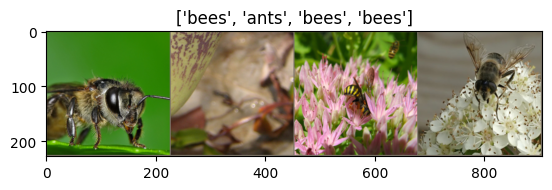

In [4]:
# вывод изображения
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# выводим очередную серию изображений
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Воспользуемся в данном случае оригинальным кодом шага обучения. Из новых вещей в нём -- параметр scheduler, **планировщик скорости обучения**, которая со временем должна снижаться.

Тут применяется такое интуитивное правило: когда скорость обучения высока, то модель будет обладать слишком высокой "кинетической энергией" -- вектор не будет уходить в достаточно узкие и глубокие локальные минимумы функции потерь. Но если скорость обучения была бы очень мала, то мы наоборот постоянно попадали бы в неглубокие и совсем узкие локальные минимумы функции потерь.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Код визуализации прогнозов для различных тестовых изображений:

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Начинается основной код.

Воспользуемся готовой моделью ResNet (resnet18) с флажком pretrained, указывающим, что надо сразу использовать обученную модель, и тут же заменим её последний слой.

Настроим планировщик скорости обучения, как рекомендовано.

In [7]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features # model_ft.fc -- это слой Linear
model_ft.fc = nn.Linear(num_ftrs, 2) # подменяем оригинальный слой своим

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Будем уменьшать скорость обучения с коэффициентом 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.3MB/s]


Запустим нашу модель на переобучение.

**Предварительно укажите в настройках ноутбука поддержку GPU, иначе процесс может растянутся на десятки минут.**

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5972 Acc: 0.6926
val Loss: 0.2317 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5226 Acc: 0.7951
val Loss: 0.6303 Acc: 0.7320

Epoch 2/24
----------
train Loss: 0.6091 Acc: 0.7336
val Loss: 0.2064 Acc: 0.9216

Epoch 3/24
----------
train Loss: 1.1219 Acc: 0.7172
val Loss: 0.3016 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.7318 Acc: 0.7131
val Loss: 0.2004 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4754 Acc: 0.7787
val Loss: 0.2943 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3417 Acc: 0.8770
val Loss: 0.2122 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2870 Acc: 0.8852
val Loss: 0.1961 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3447 Acc: 0.8607
val Loss: 0.1960 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3358 Acc: 0.8607
val Loss: 0.1985 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3326 Acc: 0.8689
val Loss: 0.2099 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3493 Acc: 0.8238
val Loss: 0.1905 Acc: 0.9281

Epoch 12/24
----------
t

Получим примерно такие результаты с точностью около 90-95%:

Epoch 24/24

train Loss: 0.2718 Acc: 0.9016
val Loss: 0.3111 Acc: 0.9020

Training complete in 1m 32s
Best val Acc: 0.941176

Визуально проверим, как работает наша модель:


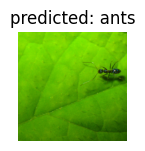

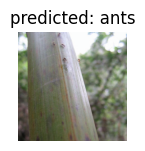

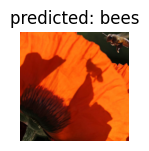

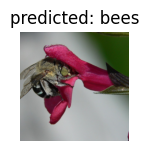

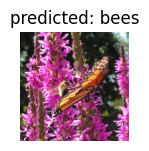

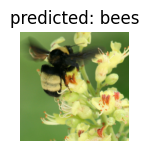

In [9]:
visualize_model(model_ft)

Теперь посмотрим, что получится, если веса оригинальной модели предварительно заморозить. Код остаётся тем же, за исключением сбрасывания флажка модели **requires_grad** (требование вычисления градиентов) в False.

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Скорость обучения модели теперь будет выше, потому что для большей части сети градиенты вычисляться уже не будут.


In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5697 Acc: 0.6803
val Loss: 0.2865 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4708 Acc: 0.8074
val Loss: 0.2927 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.4907 Acc: 0.7787
val Loss: 0.1919 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5184 Acc: 0.7582
val Loss: 0.1782 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4080 Acc: 0.7869
val Loss: 0.1943 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4953 Acc: 0.7705
val Loss: 0.1592 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3165 Acc: 0.8238
val Loss: 0.1629 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3594 Acc: 0.8443
val Loss: 0.1715 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4002 Acc: 0.8156
val Loss: 0.1711 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3647 Acc: 0.8607
val Loss: 0.1696 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3747 Acc: 0.8115
val Loss: 0.1624 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4384 Acc: 0.7828
val Loss: 0.1783 Acc: 0.9542

Ep

Получитм примерно такие результаты с точностью 90-95%:

Epoch 24/24

train Loss: 0.3331 Acc: 0.8402
val Loss: 0.1853 Acc: 0.9346

Training complete in 1m 20s
Best val Acc: 0.960784

Как видно, результат получился немного получше.


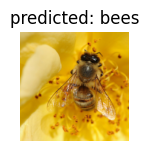

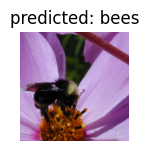

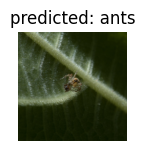

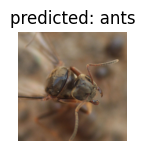

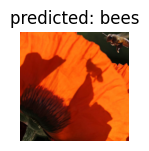

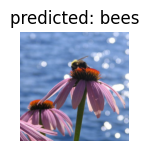

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# **Задание**

Найдите небольшой датасет, подходящий для расширения ImageNet, с классом объектов, которого в ImageNet точно нету, и дообучите готовую модель на этом датасете. Какая точность у вас получится?

---

В следующем занятии займёмся участием в соревнованиях по машинному обучению на сервисе Kaggle.

Был взял датасет собранный для целей компьютерного зрения:

https://universe.roboflow.com/rizwan-babar/ms_thesis

In [14]:
!mkdir -p "data"
!wget -N https://universe.roboflow.com/ds/7gq3cCKqNu?key=dbyN57GxrE -P "data"
!unzip -o data/7gq3cCKqNu?key=dbyN57GxrE -d data/airborne

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: data/airborne/train/labels/000000445_jpg.rf.00c51597356218321464d3365168314e.txt  
 extracting: data/airborne/train/labels/000000445_jpg.rf.11428c0050805d54118309679792e440.txt  
 extracting: data/airborne/train/labels/000000445_jpg.rf.7973ccdcf10b37f0d49a08d02a823882.txt  
 extracting: data/airborne/train/labels/000000446_jpg.rf.1b782e850df8d9fa2c55101119f426c7.txt  
 extracting: data/airborne/train/labels/000000446_jpg.rf.9f6dd99157794aeb1fdcc29778273198.txt  
 extracting: data/airborne/train/labels/000000446_jpg.rf.c034e3489bfa8bdc516a68eee3ef4979.txt  
 extracting: data/airborne/train/labels/000000447_jpg.rf.5519161fd00206f3f8de6ee2ce5e7bd1.txt  
 extracting: data/airborne/train/labels/000000447_jpg.rf.958eb4ab2a7bb06fe6f4dad5565c21e1.txt  
 extracting: data/airborne/train/labels/000000448_jpg.rf.a6b9e494969e310c1af1847c5825bf6b.txt  
 extracting: data/airborne/train/labels/000000448_jpg.rf.c569770926d

In [15]:
!cd data/airborne/train && mkdir -p "drone" "helicopter"
!cd data/airborne/valid && mkdir -p "drone" "helicopter"
!cd data/airborne/test && mkdir -p "drone" "helicopter"

In [16]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [17]:
# Обрезаем изображения до содержания
# Оставляем только интересующие классы:
# (2, 4, 6) - DRONE, (5) - Helicopter

import cv2
import os


drone = (2, 4, 6)
helicopter = (5,)


def convert_yolo_to_pixel_cords(
    x_center, y_center, width, height, img_width, img_height
):
    x_center = int(x_center * img_width)
    y_center = int(y_center * img_height)
    box_width = int(width * img_width)
    box_height = int(height * img_height)
    x_min = max(0, int(x_center - (box_width / 2)))
    y_min = max(0, int(y_center - (box_height / 2)))
    x_max = max(img_width, int(x_center + (box_width / 2)))
    y_max = max(img_height, int(y_center + (box_height / 2)))

    return x_min, y_min, x_max, y_max


def crop_image_to_content(image_path, label_path, output_path):
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    with open(label_path, "r") as file:
        line = file.readline().strip()
        parts = line.split()
        if len(parts) < 5:
            print(f"Labels error for {image_path}")
            return
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

    if class_id in drone:
        class_id = "drone"
    elif class_id in helicopter:
        class_id = "helicopter"
    else:
        return

    x_min, y_min, x_max, y_max = convert_yolo_to_pixel_cords(
        x_center, y_center, width, height, img_width, img_height
    )

    cropped_image = image[y_min:y_max, x_min:x_max]
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    output_filename = f"{base_filename}.jpg"
    output_path = os.path.join(output_path, str(class_id), output_filename)

    cv2.imwrite(output_path, cropped_image)
    print(f"Cropped image saved to {output_path}")


def process_images(image_folder, label_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(
            label_folder, filename.replace(".jpg", ".txt")
        )
        if os.path.exists(label_path):
            crop_image_to_content(image_path, label_path, output_folder)
        else:
            print(f"No label file found for {filename}")


for subfolder in ("test", "train", "valid"):
    image_folder = (
        f"./data/airborne/{subfolder}/images"
    )
    label_folder = (
        f"./data/airborne/{subfolder}/labels"
    )
    output_folder = (
        f"./data/airborne/{subfolder}/"
    )

    process_images(image_folder, label_folder, output_folder)

Cropped image saved to ./data/airborne/test/drone/video18_1240_JPEG.rf.9903453590fecec6e1e60ee7fb6f6519.jpg
Cropped image saved to ./data/airborne/test/drone/video18_1302_JPEG.rf.53252b635aa161991ebd23e72a483831.jpg
Cropped image saved to ./data/airborne/test/drone/0059_jpg.rf.b7b3f8052f9267759a4f96b6ecb9890c.jpg
Cropped image saved to ./data/airborne/test/drone/0081_jpg.rf.8fefaac8045691e57d66e79481b75e56.jpg
Cropped image saved to ./data/airborne/test/drone/video18_1601_JPEG.rf.018f15f64553ee0eba8733a219b1e941.jpg
Cropped image saved to ./data/airborne/test/drone/120_JPEG.rf.038aaa5e8f4a47a4de719b0cfd037a09.jpg
Cropped image saved to ./data/airborne/test/drone/pic_045_jpg.rf.0c7f2d3c71a15258193dd26a92ee4053.jpg
Cropped image saved to ./data/airborne/test/drone/pic_736_jpg.rf.a25475480a6ca9329e8b3c41c7f286b4.jpg
Cropped image saved to ./data/airborne/test/drone/video18_600_JPEG.rf.95ed1c60c28e2947c1e4500f9881b118.jpg
Cropped image saved to ./data/airborne/test/drone/pic_181_jpg.rf.c8f

In [154]:
!rm -rf data/airborne/train/labels
!rm -rf data/airborne/test/labels
!rm -rf data/airborne/valid/labels
!rm -rf data/airborne/train/images
!rm -rf data/airborne/test/images
!rm -rf data/airborne/valid/images

In [176]:
!rm -rf data/airborne/tmp_valid
!rm -rf data/airborne/tmp_train
!rm -rf data/airborne/tmp_test

In [177]:
for subfolder in ("train", "valid"):
    for cls in ("drone", "helicopter"):
        src = f'./data/airborne/{subfolder}/{cls}'
        dst = f'./data/airborne/tmp_{subfolder}/{cls}'

        os.makedirs(f'./data/airborne/tmp_{subfolder}/', exist_ok=True)
        os.makedirs(dst, exist_ok=True)

        files = os.listdir(src)
        files_to_copy = files[:500]

        # Копируем файлы
        for file_name in files_to_copy:
            src_path = os.path.join(src, file_name)
            dst_path = os.path.join(dst, file_name)
            shutil.copy(src_path, dst_path)

        print(f'{len(files_to_copy)} files copied to {dst}')


500 files copied to ./data/airborne/tmp_train/drone
314 files copied to ./data/airborne/tmp_train/helicopter
500 files copied to ./data/airborne/tmp_valid/drone
87 files copied to ./data/airborne/tmp_valid/helicopter


In [178]:
import random


class LimitedImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, limit=None):
        self.full_dataset = datasets.ImageFolder(root=root, transform=transform)
        self.transform = transform
        self.limit = limit
        self.indices = [i for i in range(len(self.full_dataset))]
        random.shuffle(self.indices)

    def __len__(self):
        return min(self.limit, len(self.full_dataset))

    def __getitem__(self, idx):
        if self.limit and idx >= self.limit:
            raise IndexError("Index out of range")
        return self.full_dataset[self.indices[idx]]

    @property
    def classes(self):
        return self.full_dataset.classes

In [180]:
# Выравнивание и нормализация входных изображений
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224, (0.75, 1.25)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

# загрузка двух датасетов
data_dir = "data/airborne/"
image_datasets = {
    x: LimitedImageFolder(
        os.path.join(data_dir, f"tmp_{x}"),
        data_transforms[x],
        limit=500
    )
    for x in ["train", "valid"]
}
print(image_datasets)
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
print(dataset_sizes)
class_names = image_datasets["train"].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


{'train': <__main__.LimitedImageFolder object at 0x7b67aae97340>, 'valid': <__main__.LimitedImageFolder object at 0x7b67aae96770>}
{'train': 500, 'valid': 500}
['drone', 'helicopter']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


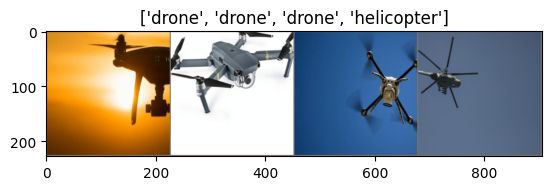

In [182]:
# вывод изображения
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# выводим очередную серию изображений
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [188]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [189]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [192]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features # model_ft.fc -- это слой Linear
model_ft.fc = nn.Linear(num_ftrs, 2) # подменяем оригинальный слой своим

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Будем уменьшать скорость обучения с коэффициентом 0.1 каждые 3 эпохи
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [193]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.5752 Acc: 0.7640
valid Loss: 0.3107 Acc: 0.8760

Epoch 1/11
----------
train Loss: 0.5644 Acc: 0.7960
valid Loss: 0.1885 Acc: 0.9180

Epoch 2/11
----------
train Loss: 0.3258 Acc: 0.8840
valid Loss: 0.1471 Acc: 0.9460

Epoch 3/11
----------
train Loss: 0.2296 Acc: 0.9100
valid Loss: 0.1084 Acc: 0.9560

Epoch 4/11
----------
train Loss: 0.2471 Acc: 0.9120
valid Loss: 0.1165 Acc: 0.9620

Epoch 5/11
----------
train Loss: 0.2648 Acc: 0.8960
valid Loss: 0.1098 Acc: 0.9600

Epoch 6/11
----------
train Loss: 0.2667 Acc: 0.8980
valid Loss: 0.1172 Acc: 0.9600

Epoch 7/11
----------
train Loss: 0.2214 Acc: 0.9040
valid Loss: 0.1356 Acc: 0.9560

Epoch 8/11
----------
train Loss: 0.2066 Acc: 0.9260
valid Loss: 0.1244 Acc: 0.9600

Epoch 9/11
----------
train Loss: 0.2382 Acc: 0.9080
valid Loss: 0.1035 Acc: 0.9700

Epoch 10/11
----------
train Loss: 0.1815 Acc: 0.9500
valid Loss: 0.1378 Acc: 0.9440

Epoch 11/11
----------
train Loss: 0.2030 Acc: 0.9160
valid Loss